<a href="https://colab.research.google.com/github/areias/healthcare_fraud/blob/main/healthcare_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Healthcare Fraud Detection

<br>

### Potential Analysis Plan (let's build on this iteratively)
* data: https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis
* first steps, data exploration and summary stats of data
* modeling: it's a binary classification problem, let's maybe try a logistic regression on it as a baseline from scikit-learn
    * https://scikit-learn.org/stable/getting_started.html
    * https://scikit-learn.org/stable/tutorial/index.html#tutorial-menu
    * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

* Graph analysis: create a schema to upload to neo4j as a graph database
* modeling plus: try graph machine learning models on it 
* experiment tracking https://wandb.ai/ and integrating with scikit-learn https://docs.wandb.ai/guides/integrations/scikit
* Because only 10% of records are fraudulent we could try some imbalanced data
processing methods such as oversampling 

<br>

### Other potentially useful information
* This document describes a dataset very similar to this one so I think we can assume that the diagnosis codes are the same ICD-9 and the 
* https://www.hipaaspace.com/Medical_Billing/Coding/ICD-9/Diagnosis/2768
* the variables  NoOfMonths_PartACov and NoOfMonths_PartBCov refer to the months the patient was covered by one of two Medicare programs: Fee-for-Service (FFS) Part A and Part B.
* this paper does this for reals http://www.karlbranting.net/papers/FOSINT_Branting_et_al.pdf


<br>

### Examples of other's analysis and results so we can compare (and be better! ha)

* https://kundusoumya98.medium.com/healthcare-provider-fraud-detection-and-analysis-using-machine-learning-632f7a380c79 - best F1 is 0.49
* https://medium.com/analytics-vidhya/provider-fraud-detection-in-the-healthcare-domain-a6f76f76d8ba - best F1 is 0.65 with xgb classifier but logistic regressionhas f1 of 0.63 so not that much worse
* https://github.com/sitathomas/Healthcare_Fraud/blob/main/Presentation_Slides.pdf - their f1 must be around 0.64 (I had to guesstimate based on their ROC curve for the Gradient boosting model)
* https://github.com/anikmanik04/healthcare-provider-fraud-detection/blob/main/07_Final_Pipeline_CS1.ipynb - best f1 0.61 from Random Forest model










In [ ]:
!wget https://github.com/areias/healthcare_fraud/blob/main/schema_draft_3.png

--2021-11-24 21:49:44--  https://github.com/areias/healthcare_fraud/blob/main/schema_draft_3.png
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘schema_draft_3.png’

schema_draft_3.png      [ <=>                ] 154.60K  --.-KB/s    in 0.1s    

2021-11-24 21:49:45 (1.33 MB/s) - ‘schema_draft_3.png’ saved [158314]



### Draft Neo4j Schema

<img src="https://github.com/areias/healthcare_fraud/blob/main/schema_draft_3.png?raw=1" height="600" />


# Project understanding: 
Project Objectives
Provider Fraud is one of the biggest problems facing Medicare. According to the government, the total Medicare spending increased exponentially due to frauds in Medicare claims. Healthcare fraud is an organized crime which involves peers of providers, physicians, beneficiaries acting together to make fraud claims.

Rigorous analysis of Medicare data has yielded many physicians who indulge in fraud. They adopt ways in which an ambiguous diagnosis code is used to adopt costliest procedures and drugs. Insurance companies are the most vulnerable institutions impacted due to these bad practices. Due to this reason, insurance companies increased their insurance premiums and as result healthcare is becoming costly matter day by day.

Healthcare fraud and abuse take many forms. Some of the most common types of frauds by providers are:

a) Billing for services that were not provided.

b) Duplicate submission of a claim for the same service.

c) Misrepresenting the service provided.

d) Charging for a more complex or expensive service than was actually provided.

e) Billing for a covered service when the service actually provided was not covered.

Problem Statement
The goal of this project is to " predict the potentially fraudulent providers " based on the claims filed by them.along with this, we will also discover important variables helpful in detecting the behaviour of potentially fraud providers. further, we will study fraudulent patterns in the provider's claims to understand the future behaviour of providers.

Introduction to the Dataset
For the purpose of this project, we are considering Inpatient claims, Outpatient claims and Beneficiary details of each provider. Lets s see their details :

A) Inpatient Data

This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit d diagnosis code.

B) Outpatient Data

This data provides details about the claims filed for those patients who visit hospitals and not admitted in it.

C) Beneficiary Details Data

This data contains beneficiary KYC details like health conditions,regioregion they belong to etc.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_ben=pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
train_in=pd.read_csv('Train_Inpatientdata-1542865627584.csv')
train_out=pd.read_csv('Train_Outpatientdata-1542865627584.csv', engine='python')
train=pd.read_csv('Train-1542865627584.csv')

In [5]:
train.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [4]:
train.shape

(5410, 2)

**Checking for unbalanced data:**

In [5]:
train.PotentialFraud.unique()

array(['No', 'Yes'], dtype=object)

In [6]:
train['PotentialFraud'].value_counts(normalize=True)*100

No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64

In [7]:
train.isna().sum()

Provider          0
PotentialFraud    0
dtype: int64

## Beneficiary Dataset:

In [96]:
train_ben.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [ ]:
train_ben.shape

(138556, 25)

In [ ]:
test_ben.shape

(63968, 25)

In [ ]:
train_ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [ ]:
train_ben.describe()

,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,1.570932,1.254511,25.666734,374.424745,11.907727,11.910145,1.667817,1.506322,1.687643,1.880041,1.762847,1.644476,1.398142,1.324143,1.725317,1.743180,1.920942,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,0.324914,0.425339,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,1.000000,1.000000,11.000000,141.000000,12.000000,12.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,40.000000
50%,2.000000,1.000000,25.000000,340.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,570.000000,170.000000
75%,2.000000,1.000000,39.000000,570.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2280.000000,1068.000000,1500.000000,460.000000
max,2.000000,5.000000,54.000000,999.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,161470.000000,38272.000000,102960.000000,13840.000000


**Checking for missing values:**

In [ ]:
train_ben.isna().sum()

BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnualReimbursementAmt          

**Checking variables' correlation**

In [ ]:
train_ben.corr().round(2)

,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
Gender,1.00,0.00,0.01,0.00,0.01,0.01,-0.02,-0.01,-0.01,0.01,-0.01,-0.02,-0.02,-0.01,-0.02,-0.01,-0.00,0.00,-0.00,0.01,0.01
Race,0.00,1.00,-0.05,-0.00,-0.01,-0.00,-0.00,0.00,-0.00,0.01,0.00,-0.01,0.00,0.01,0.01,0.00,0.00,-0.00,-0.00,0.00,0.00
State,0.01,-0.05,1.00,0.13,-0.00,0.00,0.00,-0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
County,0.00,-0.00,0.13,1.00,0.01,0.01,-0.01,-0.01,-0.01,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,0.00,0.00,0.01,0.01
NoOfMonths_PartACov,0.01,-0.01,-0.00,0.01,1.00,0.24,-0.02,-0.02,-0.02,-0.01,-0.02,-0.02,-0.04,-0.03,-0.01,-0.02,-0.01,-0.00,0.00,0.01,0.01
NoOfMonths_PartBCov,0.01,-0.00,0.00,0.01,0.24,1.00,-0.02,-0.03,-0.03,-0.01,-0.02,-0.02,-0.05,-0.04,-0.02,-0.02,-0.01,0.00,0.01,0.02,0.02
ChronicCond_Alzheimer,-0.02,-0.00,0.00,-0.01,-0.02,-0.02,1.00,0.20,0.20,0.06,0.18,0.18,0.21,0.17,0.09,0.11,0.13,-0.13,-0.16,-0.09,-0.10
ChronicCond_Heartfailure,-0.01,0.00,-0.00,-0.01,-0.02,-0.03,0.20,1.00,0.31,0.09,0.26,0.17,0.29,0.29,0.10,0.15,0.14,-0.18,-0.20,-0.15,-0.15
ChronicCond_KidneyDisease,-0.01,-0.00,-0.00,-0.01,-0.02,-0.03,0.20,0.31,1.00,0.12,0.26,0.18,0.31,0.25,0.10,0.16,0.15,-0.27,-0.27,-0.21,-0.21
ChronicCond_Cancer,0.01,0.01,0.01,-0.00,-0.01,-0.01,0.06,0.09,0.12,1.00,0.11,0.05,0.10,0.10,0.05,0.07,0.04,-0.09,-0.09,-0.07,-0.08


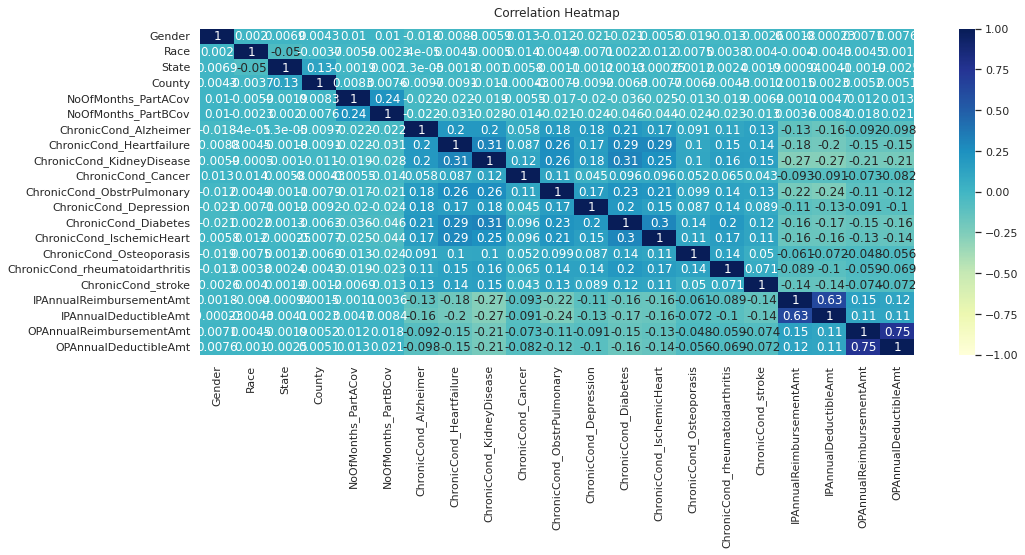

In [ ]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_ben.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

**Data Visualization**

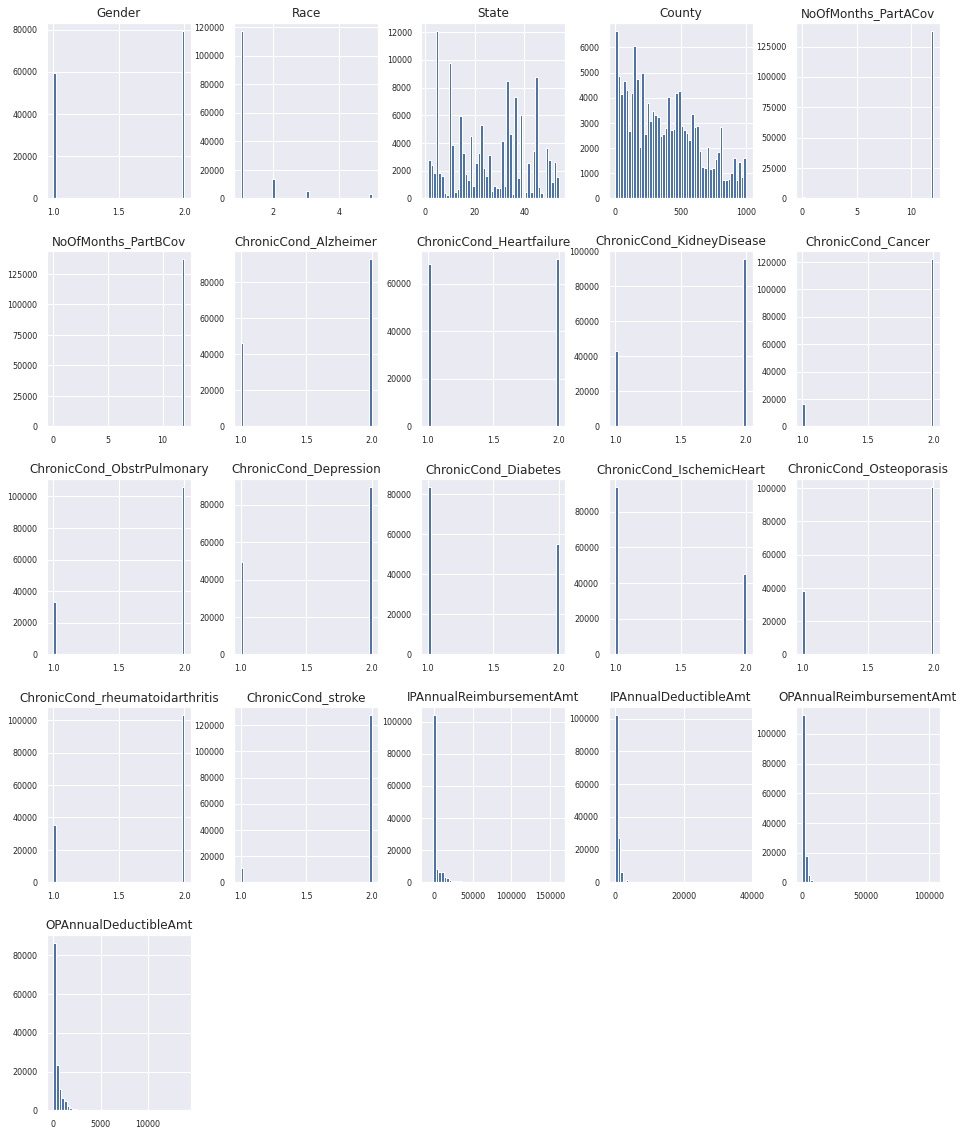

In [ ]:
train_ben.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Inpatient Dataset: 

In [ ]:
train_in.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_in['ClaimID'].nunique()

40474

In [ ]:
train_in['BeneID'].nunique()

31289

In [ ]:
train_in['Provider'].nunique()

2092

In [ ]:
train_in.shape

(40474, 30)

In [ ]:
train_in.describe()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
count,40474.000000,39575.0,23148.000000,5454.000000,965.000000,116.000000,9.000000,0.0
mean,10087.884074,1068.0,5894.611759,4103.738174,4226.355440,4070.172414,5269.444444,NaN
std,10303.099402,0.0,3049.304400,2028.182156,2282.761581,1994.409802,2780.071632,NaN
min,0.000000,1068.0,11.000000,42.000000,42.000000,42.000000,2724.000000,NaN
25%,4000.000000,1068.0,3848.000000,2724.000000,2724.000000,2758.750000,4139.000000,NaN
50%,7000.000000,1068.0,5369.000000,4019.000000,4019.000000,4019.000000,4139.000000,NaN
75%,12000.000000,1068.0,8666.250000,4439.000000,5185.000000,4439.000000,5185.000000,NaN
max,125000.000000,1068.0,9999.000000,9999.000000,9999.000000,9986.000000,9982.000000,NaN


In [ ]:
train_in.isna().sum()

BeneID                        0
ClaimID                       0
ClaimStartDt                  0
ClaimEndDt                    0
Provider                      0
InscClaimAmtReimbursed        0
AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
AdmissionDt                   0
ClmAdmitDiagnosisCode         0
DeductibleAmtPaid           899
DischargeDt                   0
DiagnosisGroupCode            0
ClmDiagnosisCode_1            0
ClmDiagnosisCode_2          226
ClmDiagnosisCode_3          676
ClmDiagnosisCode_4         1534
ClmDiagnosisCode_5         2894
ClmDiagnosisCode_6         4838
ClmDiagnosisCode_7         7258
ClmDiagnosisCode_8         9942
ClmDiagnosisCode_9        13497
ClmDiagnosisCode_10       36547
ClmProcedureCode_1        17326
ClmProcedureCode_2        35020
ClmProcedureCode_3        39509
ClmProcedureCode_4        40358
ClmProcedureCode_5        40465
ClmProcedureCode_6        40474
dtype: int64

In [ ]:
train_in.corr().round(2)

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
InscClaimAmtReimbursed,1.00,NaN,-0.15,0.11,0.13,-0.09,0.66,NaN
DeductibleAmtPaid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClmProcedureCode_1,-0.15,NaN,1.00,0.03,0.05,0.10,0.73,NaN
ClmProcedureCode_2,0.11,NaN,0.03,1.00,0.03,0.08,0.65,NaN
ClmProcedureCode_3,0.13,NaN,0.05,0.03,1.00,0.14,-0.13,NaN
ClmProcedureCode_4,-0.09,NaN,0.10,0.08,0.14,1.00,0.30,NaN
ClmProcedureCode_5,0.66,NaN,0.73,0.65,-0.13,0.30,1.00,NaN
ClmProcedureCode_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

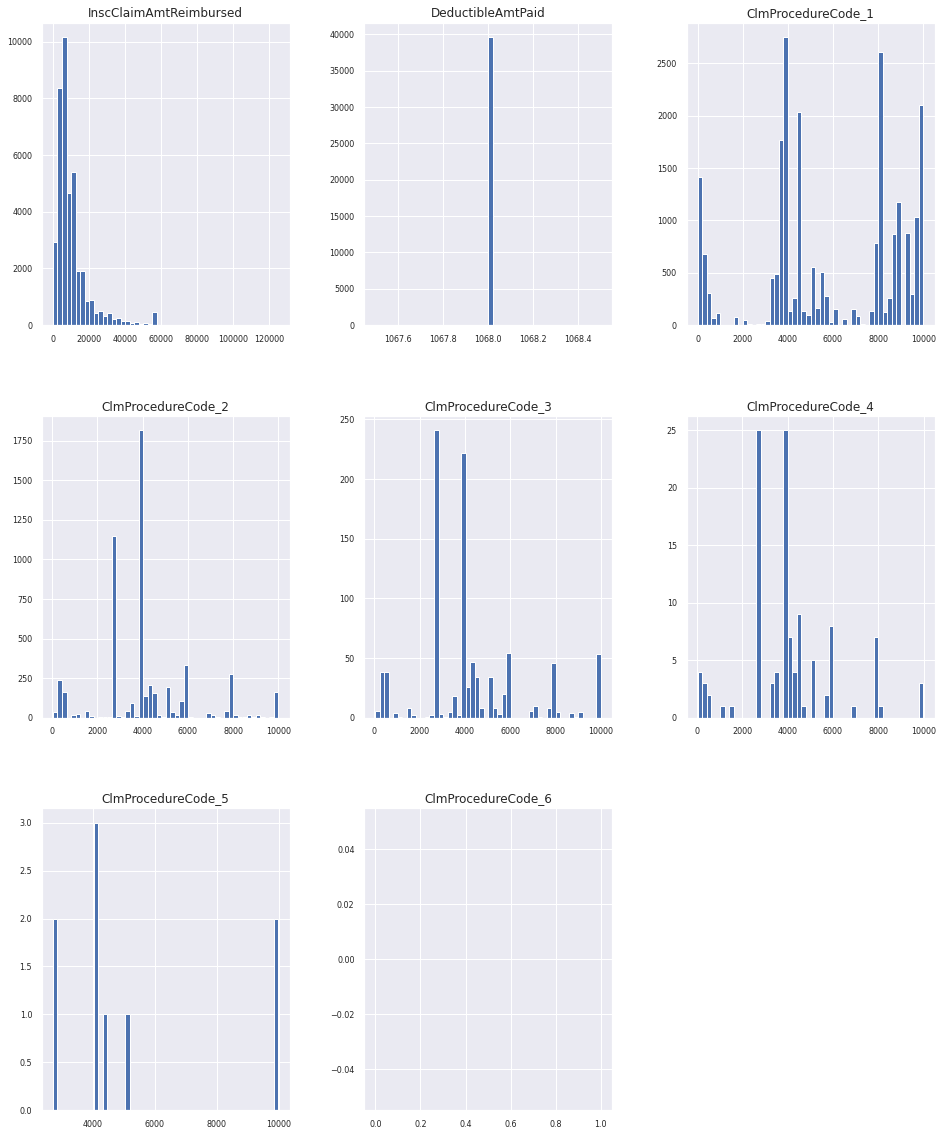

In [ ]:
train_in.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Outpatient Dataset:

In [ ]:
train_out.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [ ]:
train_out.shape

(517737, 27)

In [ ]:
train_out['Provider'].nunique()

5012

In [ ]:
train_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  517737 non-null  object 
 1   ClaimID                 517737 non-null  object 
 2   ClaimStartDt            517737 non-null  object 
 3   ClaimEndDt              517737 non-null  object 
 4   Provider                517737 non-null  object 
 5   InscClaimAmtReimbursed  517737 non-null  int64  
 6   AttendingPhysician      516341 non-null  object 
 7   OperatingPhysician      90617 non-null   object 
 8   OtherPhysician          195046 non-null  object 
 9   ClmDiagnosisCode_1      507284 non-null  object 
 10  ClmDiagnosisCode_2      322357 non-null  object 
 11  ClmDiagnosisCode_3      203257 non-null  object 
 12  ClmDiagnosisCode_4      125596 non-null  object 
 13  ClmDiagnosisCode_5      74344 non-null   object 
 14  ClmDiagnosisCode_6  

In [ ]:
train_out.describe()

,InscClaimAmtReimbursed,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid
count,517737.000000,162.000000,36.000000,4.000000,2.000000,0.0,0.0,517737.000000
mean,286.334799,6116.611111,4503.277778,2959.000000,4075.500000,NaN,NaN,2.779233
std,694.034343,3217.719258,2504.015000,1863.455393,5323.806956,NaN,NaN,15.785839
min,0.000000,51.000000,412.000000,412.000000,311.000000,NaN,NaN,0.000000
25%,40.000000,3893.000000,2724.000000,2146.000000,2193.250000,NaN,NaN,0.000000
50%,80.000000,5244.500000,4019.000000,3511.500000,4075.500000,NaN,NaN,0.000000
75%,200.000000,9421.500000,5849.000000,4324.500000,5957.750000,NaN,NaN,0.000000
max,102500.000000,9999.000000,9982.000000,4401.000000,7840.000000,NaN,NaN,897.000000


In [ ]:
train_out.isna().sum()

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician          1396
OperatingPhysician        427120
OtherPhysician            322691
ClmDiagnosisCode_1         10453
ClmDiagnosisCode_2        195380
ClmDiagnosisCode_3        314480
ClmDiagnosisCode_4        392141
ClmDiagnosisCode_5        443393
ClmDiagnosisCode_6        468981
ClmDiagnosisCode_7        484776
ClmDiagnosisCode_8        494825
ClmDiagnosisCode_9        502899
ClmDiagnosisCode_10       516654
ClmProcedureCode_1        517575
ClmProcedureCode_2        517701
ClmProcedureCode_3        517733
ClmProcedureCode_4        517735
ClmProcedureCode_5        517737
ClmProcedureCode_6        517737
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     412312
dtype: int64

In [ ]:
train_out.corr().round(2)

,InscClaimAmtReimbursed,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid
InscClaimAmtReimbursed,1.00,-0.06,0.19,-0.65,1.0,NaN,NaN,0.09
ClmProcedureCode_1,-0.06,1.00,0.15,0.44,-1.0,NaN,NaN,-0.04
ClmProcedureCode_2,0.19,0.15,1.00,-0.49,1.0,NaN,NaN,0.22
ClmProcedureCode_3,-0.65,0.44,-0.49,1.00,-1.0,NaN,NaN,NaN
ClmProcedureCode_4,1.00,-1.00,1.00,-1.00,1.0,NaN,NaN,NaN
ClmProcedureCode_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClmProcedureCode_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeductibleAmtPaid,0.09,-0.04,0.22,NaN,NaN,NaN,NaN,1.00


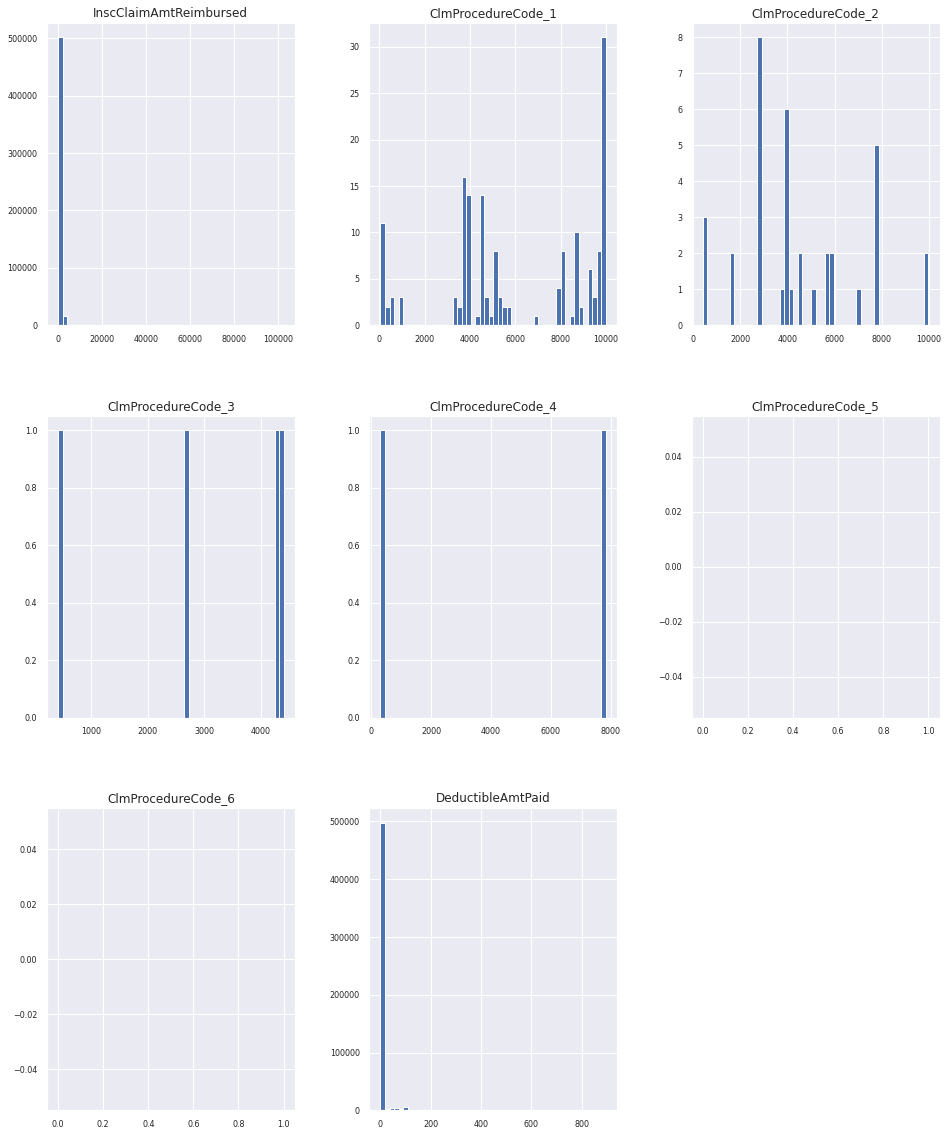

In [ ]:
train_out.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Merging the datasets:

In [4]:
train_in['Claim_type']='Inpatient'
train_out['Claim_type']='Outpatient'

In [5]:
final_train=pd.concat([train_in, train_out])
final_train=pd.merge(train_ben, final_train, on='BeneID')
final_train=pd.merge(final_train, train, on='Provider')

In [6]:
final_train.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,2,2,2,2,2,2,1,1,1,2,2,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,2,1,1,2,2,2,2,1,2,2,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,2,1,2,2,2,1,1,2,2,2,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes


In [8]:
final_train.shape

(558211, 56)

In [9]:
final_train['PotentialFraud'].value_counts(normalize=True)*100

No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64

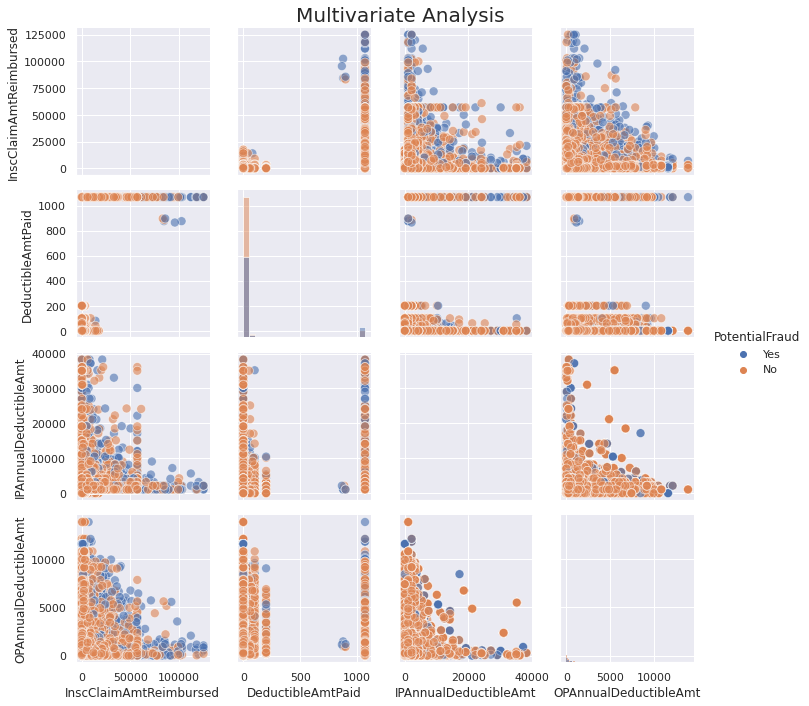

In [20]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(final_train[['InscClaimAmtReimbursed', 'DeductibleAmtPaid','IPAnnualDeductibleAmt','OPAnnualDeductibleAmt','PotentialFraud']], diag_kind="hist", hue='PotentialFraud',
plot_kws = {'alpha': 0.6, 's': 80})

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Multivariate Analysis", fontsize=20)

plt.show()

**Feature engineering:**

**Age:**

In [16]:
## AGE
# creating a timestamp for date '2009-12-01' to measure the age of live benefeciaries from this date
x = pd.to_datetime('2009-12-01',format='%Y-%m-%d')
#print(type(x))
# creating a series age with all age ewual to zero
final_train['Age']=0
# Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)
final_train['DOB'] = pd.to_datetime(final_train['DOB'] , format = '%Y-%m-%d')
final_train['DOD'] = pd.to_datetime(final_train['DOD'],format = '%Y-%m-%d',errors='ignore')
# how to calculate age feauture:- filled age column with age calculated using DOB and DOD for dead benefeciaries and
# for live benefeciary age calculated using date '2009-12-01'.
for i in range(len(final_train)):
    if type(final_train['DOD'].iloc[i])==type(x):
     final_train['Age'].iloc[i]=round(((final_train['DOD'].iloc[i]- final_train['DOB'].iloc[i])/365).days)
    else:
      final_train['Age'].iloc[i]=round(((x- final_train['DOB'].iloc[i])/365).days)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[Text(0, 0.5, 'Mean of beneficiary ages'), Text(0.5, 0, 'Fraudulent or not')]

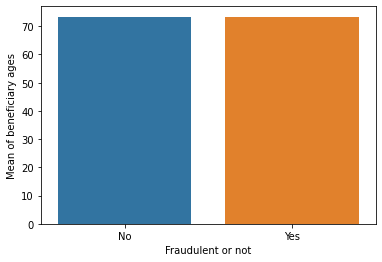

In [29]:
grp=final_train.groupby(['Provider', 'PotentialFraud','BeneID'], as_index=False)['Age'].mean() #the mean will just show the age for each beneID in this case
grp=grp.groupby(['PotentialFraud'], as_index=False)['Age'].mean()
ax=sns.barplot(x='PotentialFraud',y='Age', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean of beneficiary ages")

**Number of Physicians:**

In [17]:
#function for counting unique values in rows.
def uniq(df):
    ''' this function  takes features and count unique values in row and 
    return the count of uniqe values '''
    return ([len(set([i for i in x[pd.notnull(x)]])) for x in df.values])

#one physician could work for several roles for one patient so we need to calculate number of unique physicians per patitent
#Number of physician per patient.
final_train['NumberOFPhysicians']=uniq(final_train[['AttendingPhysician','OperatingPhysician', 'OtherPhysician']])

In [61]:
final_train.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,2,2,2,2,2,2,1,1,1,2,2,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,2,1,1,2,2,2,2,1,2,2,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,2,1,2,2,2,1,1,2,2,2,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes


[Text(0, 0.5, "Mean number of physicians for each provider's claim"),
 Text(0.5, 0, 'Fraudulent or not')]

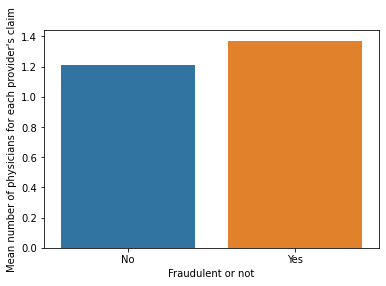

In [44]:
grp=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['NumberOFPhysicians'].mean() #the mean will just show the mean number of physicians for each provider's claim
grp=grp.groupby(['PotentialFraud'], as_index=False)['NumberOFPhysicians'].mean()
ax=sns.barplot(x='PotentialFraud',y='NumberOFPhysicians', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean number of physicians for each provider's claim")

**County**

In [15]:
grp=final_train.groupby(['Provider', 'PotentialFraud','BeneID'], as_index=False)['County'].mean() #the mean will just show the county number for each beneID in this case
grp=final_train.groupby(['County'], as_index=False)['PotentialFraud'].agg(pd.Series.mode)
grp

,County,PotentialFraud
0,0,No
1,1,No
2,10,No
3,11,No
4,14,Yes
...,...,...
309,992,No
310,993,No
311,994,Yes
312,996,Yes


**Number of chronic diseases for each beneficiary**

In [18]:
# number of ChronicCond featues
list_ChronicCond=[i for i in final_train.columns if 'ChronicCond' in i] # list of chronic_cond features
#print('len(list_ChronicCond):',len(list_ChronicCond))
#add this feature
for i in list_ChronicCond: 
  final_train[i].replace({2: 0}, inplace=True)

final_train['NumberOFChronic']=final_train[list_ChronicCond].sum(axis=1)

In [77]:
final_train.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud,NumberOFChronic
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes,7
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,0,0,0,0,0,0,1,1,1,0,0,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,3
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,0,1,1,0,0,0,0,1,0,0,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,4
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,0,1,0,0,0,1,1,0,0,0,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,4
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,0,0,0,0,1,0,0,0,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,4


[Text(0, 0.5, "Mean number of chronic disease for each provider's patient"),
 Text(0.5, 0, 'Fraudulent or not')]

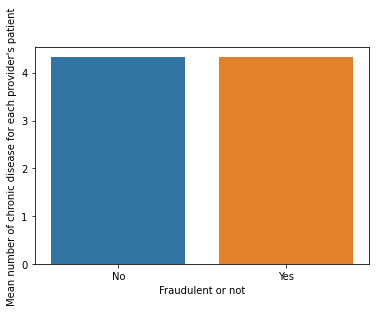

In [81]:
grp=final_train.groupby(['Provider', 'PotentialFraud','BeneID'], as_index=False)['NumberOFChronic'].mean() #the mean will just show the number of chronic diseases for each beneID in this case
grp=grp.groupby(['PotentialFraud'], as_index=False)['NumberOFChronic'].mean()
ax=sns.barplot(x='PotentialFraud',y='NumberOFChronic', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean number of chronic disease for each provider's patient")

**NumOFClmDiagnosisCode**

In [19]:
 #count of dignosis
type_of_feature_for_count='DiagnosisCode'
DignosisCodeFeats=[i for i in final_train.columns if type_of_feature_for_count in i]
 #for unique dignosis code per patient
final_train['uniqdiag']=uniq(final_train[DignosisCodeFeats])
#for dignosis_count(count if any code repeated for data point)
df=final_train
#list of feature names+_pr ,these feature tells about ClmDiagnosisCode present or not
DignosisCodeFeats_pr=[i+'_pr' for i in df.columns if type_of_feature_for_count in i]
# fillna with 0 ,means if ClmDiagnosisCode not present then 0 else 1
df[DignosisCodeFeats_pr] =np.where(df[DignosisCodeFeats].isnull(), 0, 1)
# empty feature for storing count of ClmDiagnosisCode
df['NumOFClmDiagnosisCode']=0
# adding count of ClmDiagnosisCode
for i in DignosisCodeFeats_pr:
   df['NumOFClmDiagnosisCode'] +=df[i]
#if any Dignosiscode is repeated for a patient(in datapoint) or not, this will be captured by ExtraClaims feature
df['ExtraClaims']=df['NumOFClmDiagnosisCode']-final_train['uniqdiag']

[Text(0, 0.5, "Mean number of unique diagnosis for each provider's claim"),
 Text(0.5, 0, 'Fraudulent or not')]

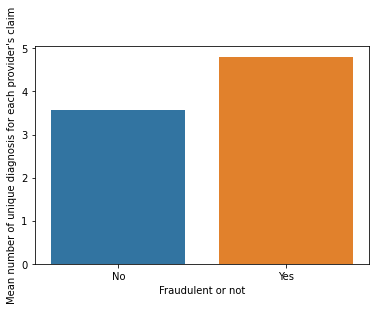

In [92]:
grp=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['uniqclaims'].mean() #the mean will just show the mean number of physicians for each provider's claim
grp=grp.groupby(['PotentialFraud'], as_index=False)['uniqclaims'].mean()
ax=sns.barplot(x='PotentialFraud',y='uniqclaims', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean number of unique diagnosis for each provider's claim")

**NumOFClmProcedureCode**

In [20]:
#Count procedure_count
type_of_feature_for_count='ProcedureCode'
ProcedureCode_feats=[i for i in final_train.columns if type_of_feature_for_count in i]
#for unique Procedure codes per patient
final_train['UniqProcedures']=uniq(final_train[ProcedureCode_feats])
#for ProcedureCode_count
df=final_train
#list of feature names+_pr ,these feature tells about ProcedureCode present or not
ProcedureCodeFeat_pr=[i+'_pr' for i in final_train.columns if type_of_feature_for_count in i]
# fillna with 0 ,means if ProcedureCode not present then 0 else 1
df[ProcedureCodeFeat_pr] =np.where(df[ProcedureCode_feats].isnull(), 0, 1)
# empty feature for storing count of ProcedureCode
df['NumOfProcedureCode']=0
# adding count of ProcedureCode
for i in ProcedureCodeFeat_pr:
  df['NumOfProcedureCode'] +=df[i]

[Text(0, 0.5, "Mean number of unique procedure for each provider's claim"),
 Text(0.5, 0, 'Fraudulent or not')]

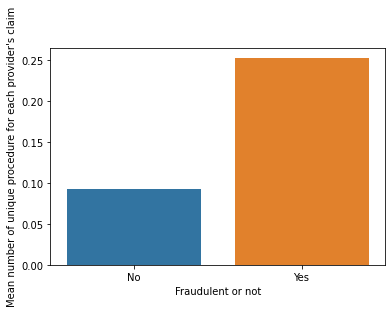

In [95]:
grp=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['UniqProcedures'].mean() #the mean will just show the mean number of physicians for each provider's claim
grp=grp.groupby(['PotentialFraud'], as_index=False)['UniqProcedures'].mean()
ax=sns.barplot(x='PotentialFraud',y='UniqProcedures', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean number of unique procedure for each provider's claim")

**Admission duration vs claim duration**

In [21]:
##DATE TO DAYS CREATED days_to_process_claim,Admit_days FEATURES
# Using admission date and discharge date create feature admit days 
final_train['AdmissionDt'] = pd.to_datetime(final_train['AdmissionDt'] , format = '%Y-%m-%d')
final_train['DischargeDt'] = pd.to_datetime(final_train['DischargeDt'],format = '%Y-%m-%d',errors='ignore')
final_train['Admit_days'] = round(((final_train['DischargeDt'] - final_train['AdmissionDt']).dt.days))
final_train['Admit_days']=final_train['Admit_days'].fillna(0)

# Add feature days_to_process_claim which says about how many days are taken to process the claim
# using claimEndDate-ClaimStartDate
final_train['ClaimStartDt'] = pd.to_datetime(final_train['ClaimStartDt'] , format = '%Y-%m-%d')
final_train['ClaimEndDt'] = pd.to_datetime(final_train['ClaimEndDt'],format = '%Y-%m-%d',errors='ignore')
final_train['DaysToProcessClaim'] = round(((final_train['ClaimEndDt'] - final_train['ClaimStartDt']).dt.days))

[Text(0, 0.5, 'Mean number of admission days per potential fraud'),
 Text(0.5, 0, 'Fraudulent or not')]

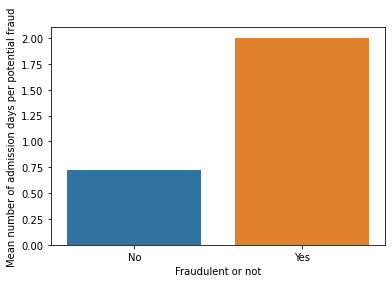

In [100]:
grp=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['Admit_days'].mean() 
grp=grp.groupby(['PotentialFraud'], as_index=False)['Admit_days'].mean()
ax=sns.barplot(x='PotentialFraud',y='Admit_days', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean number of admission days per potential fraud")

[Text(0, 0.5, 'Mean number of days to process claims per potential fraud'),
 Text(0.5, 0, 'Fraudulent or not')]

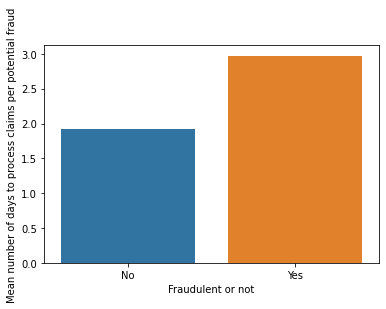

In [101]:
grp=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['DaysToProcessClaim'].mean() 
grp=grp.groupby(['PotentialFraud'], as_index=False)['DaysToProcessClaim'].mean()
ax=sns.barplot(x='PotentialFraud',y='DaysToProcessClaim', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean number of days to process claims per potential fraud")

**Number of claims**

[Text(0, 0.5, 'Number of claims'), Text(0.5, 0, 'Fraudulent or not')]

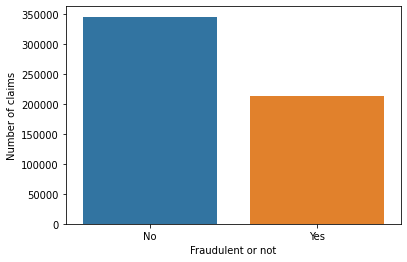

In [ ]:
groups = final_train.groupby(['PotentialFraud'], as_index=False)['ClaimID'].count()
#Drowing the barplot
ax=sns.barplot(x='PotentialFraud',y='ClaimID', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Number of claims")

**Average number of claims**

[Text(0, 0.5, 'Average number of claims'), Text(0.5, 0, 'Fraudulent or not')]

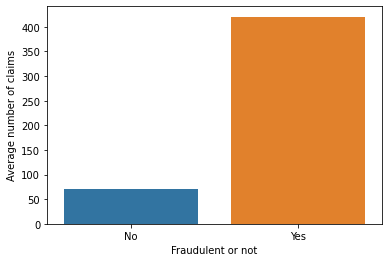

In [ ]:
groups = final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['ClaimID'].count()
groups=groups.groupby(['PotentialFraud'], as_index=False)['ClaimID'].mean()
ax=sns.barplot(x='PotentialFraud',y='ClaimID', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Average number of claims")

- IP Annual Reimbursement Amt:- Amount claimed by the beneficiary when admitted as an inpatient.
- OP Annual Reimbursement Amt:- Amount claimed by the beneficiary when admitted as an outpatient. 
- IP Annual Deductible Amt:- money inpatient should pay to the provider before applying for a claim. 
- OP Annual Deductible Amt: money outpatient should pay to the provider before applying for a claim.

**IP Annual Deductible**

[Text(0, 0.5, "Mean annual IP deductibel amount for each provider's patient"),
 Text(0.5, 0, 'Fraudulent or not')]

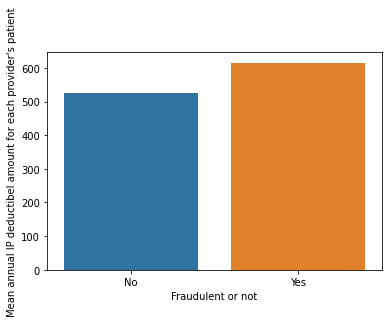

In [11]:
grp=final_train.groupby(['Provider', 'PotentialFraud','BeneID'], as_index=False)['IPAnnualDeductibleAmt'].mean() #the mean will just show the value of deductible for each beneID in this case
grp=grp.groupby(['PotentialFraud'], as_index=False)['IPAnnualDeductibleAmt'].mean()
ax=sns.barplot(x='PotentialFraud',y='IPAnnualDeductibleAmt', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean annual IP deductibel amount for each provider's patient")

**OP Annual Deductible**

[Text(0, 0.5, "Mean annual OP deductibel amount for each provider's patient"),
 Text(0.5, 0, 'Fraudulent or not')]

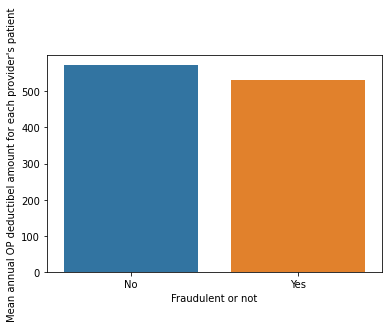

In [12]:
grp=final_train.groupby(['Provider', 'PotentialFraud','BeneID'], as_index=False)['OPAnnualDeductibleAmt'].mean() #the mean will just show the value of deductible for each beneID in this case
grp=grp.groupby(['PotentialFraud'], as_index=False)['OPAnnualDeductibleAmt'].mean()
ax=sns.barplot(x='PotentialFraud',y='OPAnnualDeductibleAmt', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Mean annual OP deductibel amount for each provider's patient")

**Insurance claim reimbursed**

[Text(0, 0.5, 'Average of insurance claim reimbursed '),
 Text(0.5, 0, 'Fraudulent or not')]

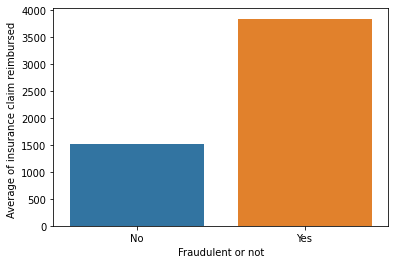

In [ ]:
groups = final_train.groupby(['Provider','PotentialFraud'], as_index=False)['InscClaimAmtReimbursed'].mean()
groups=groups.groupby(['PotentialFraud'], as_index=False)['InscClaimAmtReimbursed'].mean()
ax=sns.barplot(x='PotentialFraud',y='InscClaimAmtReimbursed', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Average of insurance claim reimbursed ")

**Claim Type**

In [ ]:
groups = final_train.groupby(['PotentialFraud', 'Claim_type'], as_index=False)['ClaimID'].count()
groups

,PotentialFraud,Claim_type,ClaimID
0,No,Inpatient,17072
1,No,Outpatient,328343
2,Yes,Inpatient,23402
3,Yes,Outpatient,189394


**Chronic diseases**

In [ ]:
groups = final_train.loc[final_train['ChronicCond_Alzheimer']==2].groupby(['PotentialFraud'], as_index=False)['ChronicCond_Alzheimer'].count()
groups

,PotentialFraud,ChronicCond_Alzheimer
0,No,207435
1,Yes,126449


[Text(0, 0.5, 'Percentage of claims with Alzheimer'),
 Text(0.5, 0, 'Fraudulent or not')]

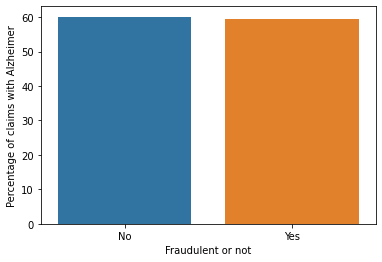

In [ ]:
Alz = final_train.loc[final_train['ChronicCond_Alzheimer']==2].groupby(['Provider','PotentialFraud'], as_index=False)['ChronicCond_Alzheimer'].count()
total=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['ClaimID'].count()
groups=pd.merge(Alz, total, on=['Provider','PotentialFraud'])
groups=groups.groupby(['PotentialFraud'], as_index=False)[['ChronicCond_Alzheimer','ClaimID']].sum()
groups['Alzheimer_per']=(groups['ChronicCond_Alzheimer']/groups['ClaimID'])*100
ax=sns.barplot(x='PotentialFraud',y='Alzheimer_per', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Percentage of claims with Alzheimer")

[Text(0, 0.5, 'Percentage of claims with Depression'),
 Text(0.5, 0, 'Fraudulent or not')]

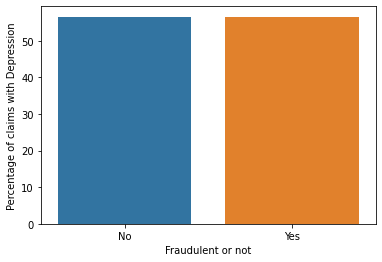

In [ ]:
Dep = final_train.loc[final_train['ChronicCond_Depression']==2].groupby(['Provider','PotentialFraud'], as_index=False)['ChronicCond_Depression'].count()
total=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['ClaimID'].count()
groups=pd.merge(Dep, total, on=['Provider','PotentialFraud'])
groups=groups.groupby(['PotentialFraud'], as_index=False)[['ChronicCond_Depression','ClaimID']].sum()
groups['Depression_per']=(groups['ChronicCond_Depression']/groups['ClaimID'])*100
ax=sns.barplot(x='PotentialFraud',y='Depression_per', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Percentage of claims with Depression")

[Text(0, 0.5, 'Percentage of claims with Heartfailure'),
 Text(0.5, 0, 'Fraudulent or not')]

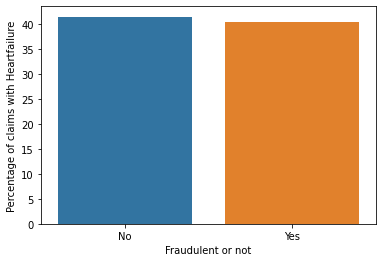

In [ ]:
heart = final_train.loc[final_train['ChronicCond_Heartfailure']==2].groupby(['Provider','PotentialFraud'], as_index=False)['ChronicCond_Heartfailure'].count()
total=final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['ClaimID'].count()
groups=pd.merge(heart, total, on=['Provider','PotentialFraud'])
groups=groups.groupby(['PotentialFraud'], as_index=False)[['ChronicCond_Heartfailure','ClaimID']].sum()
groups['heartfailure_per']=(groups['ChronicCond_Heartfailure']/groups['ClaimID'])*100
ax=sns.barplot(x='PotentialFraud',y='heartfailure_per', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Percentage of claims with Heartfailure")

**Attending Physician**

In [ ]:
groups = final_train.groupby(['Provider', 'PotentialFraud','AttendingPhysician'], as_index=False)['ClaimID'].count()
groups

,Provider,PotentialFraud,AttendingPhysician,ClaimID
0,PRV51001,No,PHY311126,1
1,PRV51001,No,PHY318842,1
2,PRV51001,No,PHY340163,1
3,PRV51001,No,PHY345302,4
4,PRV51001,No,PHY346762,1
...,...,...,...,...
87900,PRV57760,No,PHY398330,4
87901,PRV57761,No,PHY354815,68
87902,PRV57761,No,PHY367727,14
87903,PRV57762,No,PHY432730,1


In [ ]:
groups.loc[groups['ClaimID']>700]

,Provider,PotentialFraud,AttendingPhysician,ClaimID
2903,PRV51196,No,PHY432614,716
3084,PRV51244,Yes,PHY318667,711
5072,PRV51369,Yes,PHY347064,1076
5073,PRV51369,Yes,PHY383481,1005
6804,PRV51459,Yes,PHY314027,1200
6805,PRV51459,Yes,PHY327046,1181
6806,PRV51459,Yes,PHY337425,1156
6807,PRV51459,Yes,PHY338032,1158
6808,PRV51459,Yes,PHY341578,1133
6809,PRV51459,Yes,PHY357120,1156


In [ ]:
grp1 = final_train.groupby(['Provider'], as_index=False)['ClaimID'].count()
grp1

,Provider,ClaimID
0,PRV51001,25
1,PRV51003,132
2,PRV51004,149
3,PRV51005,1165
4,PRV51007,72
...,...,...
5405,PRV57759,28
5406,PRV57760,22
5407,PRV57761,82
5408,PRV57762,1


In [ ]:
grp2 = final_train.groupby(['Provider', 'PotentialFraud'], as_index=False)['AttendingPhysician'].nunique()
grp2

,Provider,PotentialFraud,AttendingPhysician
0,PRV51001,No,14
1,PRV51003,Yes,44
2,PRV51004,No,38
3,PRV51005,Yes,6
4,PRV51007,No,10
...,...,...,...
5405,PRV57759,No,1
5406,PRV57760,No,3
5407,PRV57761,No,2
5408,PRV57762,No,1


[Text(0, 0.5, 'Average number of physician'),
 Text(0.5, 0, 'Fraudulent or not')]

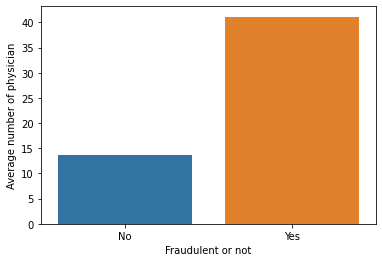

In [ ]:
groups=grp2.groupby(['PotentialFraud'], as_index=False)[['AttendingPhysician']].mean()
ax=sns.barplot(x='PotentialFraud',y='AttendingPhysician', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Average number of physician")

[Text(0, 0.5, 'Number of claims per physician'),
 Text(0.5, 0, 'Fraudulent or not')]

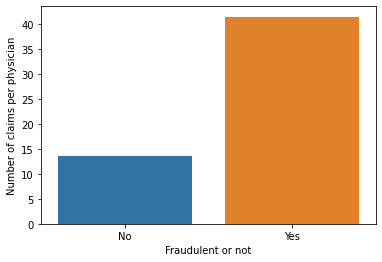

In [ ]:
groups=pd.merge(grp1, grp2, on=['Provider'])
groups['Number of claims per physician']= groups['ClaimID']/groups['AttendingPhysician']
groups=groups.groupby(['PotentialFraud'], as_index=False)[['Number of claims per physician']].mean()
ax=sns.barplot(x='PotentialFraud',y='Number of claims per physician', data=groups)
ax.set(xlabel="Fraudulent or not", ylabel = "Number of claims per physician")

**Graph Features**

In [ ]:
score=pd.read_csv('score.csv')
score=score.drop(['Unnamed: 0'], axis = 1)
score

,nodeCount,max_centralityDistribution,meanscore,maxscore,componentCount,Provider,PotentialFraud
0,225,0.174390,1.231115,47.000237,4,PRV54572,No
1,20,0.420378,0.900002,6.000015,2,PRV53390,No
2,21,0.229393,0.904762,11.000000,2,PRV56999,No
3,128,0.095331,0.859376,9.000031,18,PRV51934,No
4,24,0.493816,0.916670,9.000053,2,PRV53177,No
...,...,...,...,...,...,...,...
5405,73,0.331263,0.808221,7.000023,14,PRV51387,No
5406,100,0.216396,0.780002,16.000114,22,PRV51355,No
5407,87,0.246661,1.183911,45.000122,1,PRV55322,No
5408,19,0.235690,0.947368,18.000000,1,PRV55881,No


**Node Count**

The number of nodes stored in the subgraph.

[Text(0, 0.5, 'Average node count'), Text(0.5, 0, 'Fraudulent or not')]

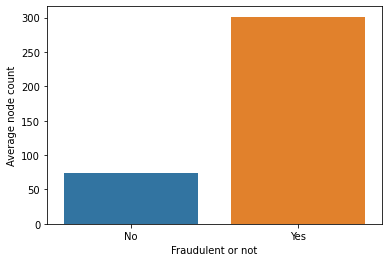

In [ ]:
grp = score.groupby(['PotentialFraud'], as_index=False)['nodeCount'].mean()
ax=sns.barplot(x='PotentialFraud',y='nodeCount', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Average node count")

**Eigenvector Centrality**

Eigenvector Centrality is an algorithm that measures the transitive influence of nodes. Relationships originating from high-scoring nodes contribute more to the score of a node than connections from low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

[Text(0, 0.5, 'Average max centrality distribution'),
 Text(0.5, 0, 'Fraudulent or not')]

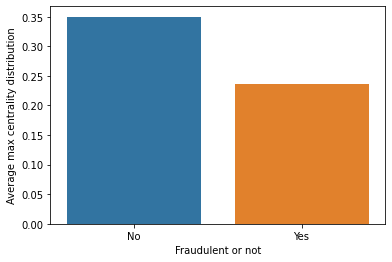

In [ ]:
grp = score.groupby(['PotentialFraud'], as_index=False)['max_centralityDistribution'].mean()
ax=sns.barplot(x='PotentialFraud',y='max_centralityDistribution', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Average max centrality distribution")

**Degree Centrality**

The Degree Centrality algorithm can be used to find popular nodes within a graph. Degree centrality measures the number of incoming or outgoing (or both) relationships from a node, depending on the orientation of a relationship projection. 

[Text(0, 0.5, 'Average mean degree score'), Text(0.5, 0, 'Fraudulent or not')]

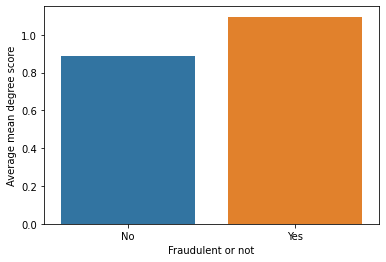

In [ ]:
grp = score.groupby(['PotentialFraud'], as_index=False)['meanscore'].mean()
ax=sns.barplot(x='PotentialFraud',y='meanscore', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Average mean degree score")

[Text(0, 0.5, 'Average max degree score'), Text(0.5, 0, 'Fraudulent or not')]

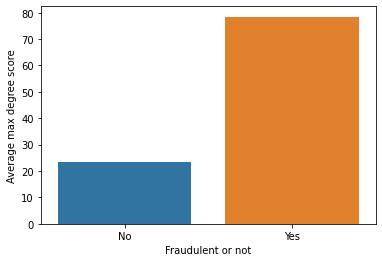

In [ ]:
grp = score.groupby(['PotentialFraud'], as_index=False)['maxscore'].mean()
ax=sns.barplot(x='PotentialFraud',y='maxscore', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Average max degree score")

**Component Count**

The WCC algorithm finds sets of connected nodes in an undirected graph, where all nodes in the same set form a connected component. 

[Text(0, 0.5, 'Average component count'), Text(0.5, 0, 'Fraudulent or not')]

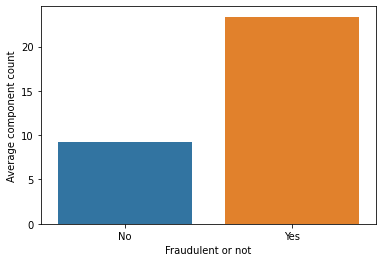

In [ ]:
grp = score.groupby(['PotentialFraud'], as_index=False)['componentCount'].mean()
ax=sns.barplot(x='PotentialFraud',y='componentCount', data=grp)
ax.set(xlabel="Fraudulent or not", ylabel = "Average component count")

In [22]:
#Export the final_train
final_train.to_csv('Final_df.csv',index = False)